# The Future is Now: Patterns in Global Temperature Trends Across the World

Continued from `Analysis 2 Cluster k-means.ipynb`.

## Dependency Installation & Imports

In [1]:
%pip install pandas numpy scikit-learn matplotlib missingno pyarrow pycountry_convert kgcpy scipy fastdtw statsmodels networkx pyvis

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastdtw import fastdtw
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import euclidean
from scipy.stats import linregress

In [3]:
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', 12)
global_correlation = 0.8770524844965029

## Further Pattern Examination

### Data Preparation (Standardization)

In [4]:
with open('Data_augmented.csv', 'r') as file:
    df = pd.read_csv(file)

df = df.drop(['Latitude', 'Longitude', 'AbsLatitude', 'AbsLongitude'], axis=1)

df.head()

,City,Year,AverageTemperature,Country,NumericLatitude,NumericLongitude,Continent,kcc
0,Abidjan,1880,25.957083,Cote D'Ivoire,5.63,-3.23,Africa,Aw
1,Abidjan,1881,26.073333,Cote D'Ivoire,5.63,-3.23,Africa,Aw
2,Abidjan,1882,25.687167,Cote D'Ivoire,5.63,-3.23,Africa,Aw
3,Abidjan,1883,26.131333,Cote D'Ivoire,5.63,-3.23,Africa,Aw
4,Abidjan,1884,26.366625,Cote D'Ivoire,5.63,-3.23,Africa,Aw


In [5]:
# Create a temperature profile for each city
city_profiles = df.pivot(index='Year', columns='City', values='AverageTemperature').ffill().bfill()

# Normalize with z-scores
city_profiles_standardized = (city_profiles - city_profiles.mean()) / city_profiles.std()

for city in city_profiles_standardized:
    assert city_profiles_standardized[city].values.ndim == 1, f"{city} profile is not 1-D"

# Euclidean distances between all city pairs
distances_euclid = pdist(city_profiles_standardized.transpose(), metric='euclidean')

# condensed distance matrix -> square
matrix_euclid = squareform(distances_euclid)

# DTW distance matrix
cities = city_profiles_standardized.columns
num_cities = len(cities)
matrix_dtw = np.zeros((num_cities, num_cities))

# Inputs need to be 1 dimensional
def euclidean_distance_wrapper(x, y):
    x_flat = np.array(x).flatten()
    y_flat = np.array(y).flatten()
    return euclidean(x_flat, y_flat)

for i in range(num_cities):
    # Only need upper triangle since it will be symmetrical about the diagonal
    for j in range(i + 1, num_cities):
        city1, city2 = cities[i], cities[j]
        distance, _ = fastdtw(city_profiles_standardized[city1].values, city_profiles_standardized[city2].values, dist=euclidean_distance_wrapper)
        # Make it symmetrical
        matrix_dtw[i, j] = distance
        matrix_dtw[j, i] = distance
        
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
matrix_cities = mds.fit_transform(matrix_dtw)

### Hierarchical Clustering

Create a dendrogam to help estimate how many clusters to use; could find the largest vertical distance that does not intersect any clusters.

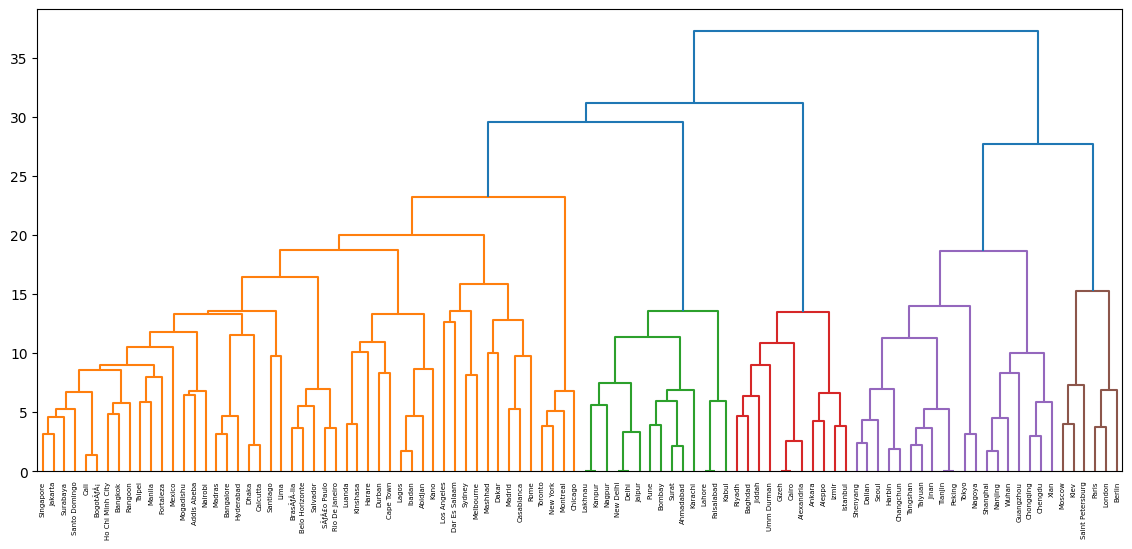

In [7]:
plt.figure(figsize=(14, 6))
linked = linkage(distances_euclid, 'ward')  # 'ward' method minimizes the variance of clusters being merged
dendrogram(linked, labels=city_profiles_standardized.columns.array, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

Apply heuristic approaches to try to determine optimal number of clusters.

In [8]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster
    
max_score = -1
optimal_clusters = 0
linked = linkage(city_profiles_standardized.transpose(), 'ward')

for num_clusters in range(2, 11):  # Example range, adjust as needed
    labels = fcluster(linked, num_clusters, criterion='maxclust')
    score = silhouette_score(city_profiles_standardized.transpose(), labels, metric='euclidean')
    
    if score > max_score:
        max_score = score
        optimal_clusters = num_clusters

print(f'Optimal number of clusters: {optimal_clusters}, Silhouette Score: {max_score}')

Optimal number of clusters: 7, Silhouette Score: 0.22825496787611668


Silhouette score vs. number of clusters visualization

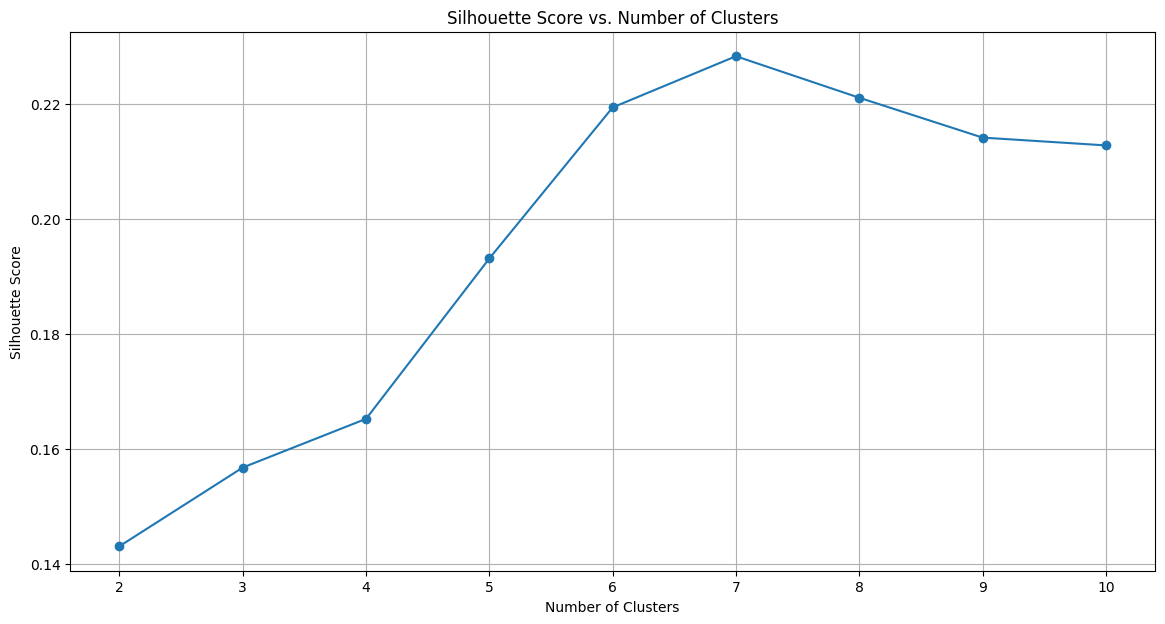

In [9]:
cluster_range = range(2, 11)
silhouette_scores = []

for n_clusters in cluster_range:
    labels = fcluster(linked, n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(city_profiles_standardized.transpose(), labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(14, 7))
plt.subplot(1, 1, 1)  # Adjusted for a single plot focus on silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

The plot agrees with our calculation - it looks like 7 is the optimal number of clusters. Let's continue.

In [10]:
n_clusters = optimal_clusters

agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
agg_labels = agg_clustering.fit_predict(city_profiles_standardized.transpose())

# Correctly associate cluster labels with cities
cities = city_profiles_standardized.columns
city_cluster_map = pd.DataFrame({'City': cities, 'Cluster': agg_labels})

In [11]:
df_hierarchical = pd.merge(df, city_cluster_map, on='City', how='left').drop_duplicates(subset='City', keep='first')
df_hierarchical = df_hierarchical[['Country', 'NumericLatitude', 'NumericLongitude', 'Continent', 'kcc', 'City', 'Cluster']]

df_hierarchical = df_hierarchical.sort_values(by=['Cluster', 'City']).reset_index(drop=True)

outfile = 'Data_hierarchical.csv'
df_hierarchical.to_csv(f'{outfile}', index=False)

print(f'Exported clustered cities to {outfile}')

Exported clustered cities to Data_hierarchical.csv


#### Cluster visualizations

1. Unique Cities in each cluster
2. Unique Countries in each cluster
3. Proportion of Continents in each cluster relative to all data
   1. Bar graph with absolute abundance
   2. Heat map with relative abundance
4. Proportion of climates in each cluster relative to all data
   1. Bar graph with absolute abundance
   2. Heat map with relative abundance
5. For each cluster:
   1. Averaged AverageTemperature by Year & correlations
   2. AverageTemperature by Year & correlations
   3. Box & Whiskers plots to look at geographic spread (Latitude, Longitude)

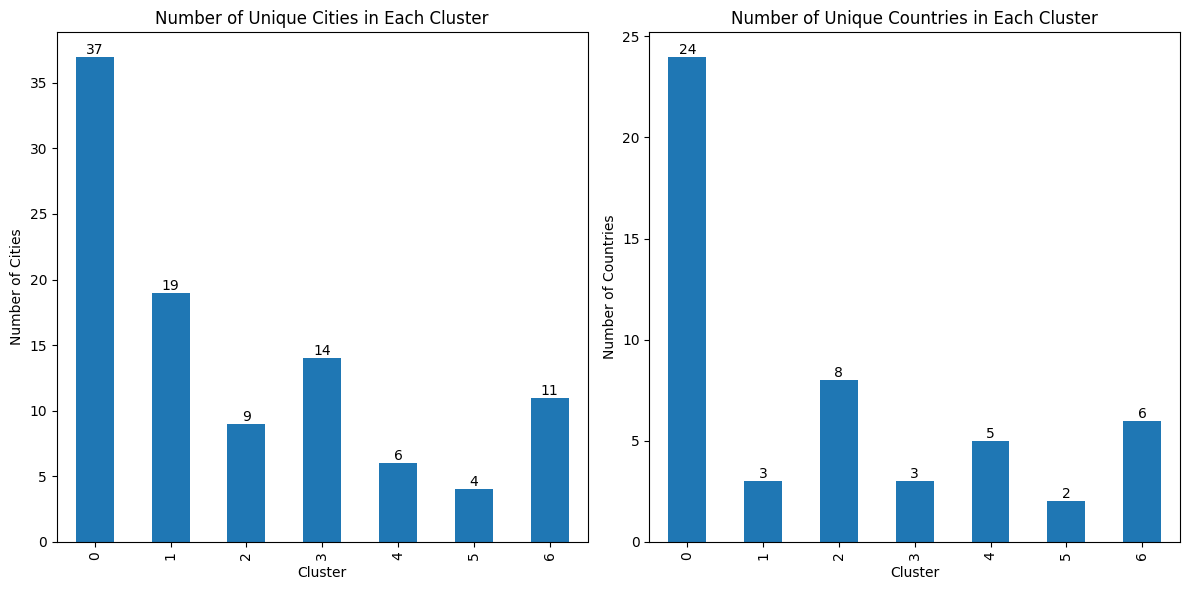

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
cities_per_cluster = df_hierarchical.groupby('Cluster')['City'].nunique()
cities_per_cluster.plot(kind='bar')
plt.title('Number of Unique Cities in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Cities')
for index, value in enumerate(cities_per_cluster):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.subplot(1, 2, 2)
countries_per_cluster = df_hierarchical.groupby('Cluster')['Country'].nunique()
countries_per_cluster.plot(kind='bar')
plt.title('Number of Unique Countries in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Countries')
for index, value in enumerate(countries_per_cluster):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Visualize each averaged cluster

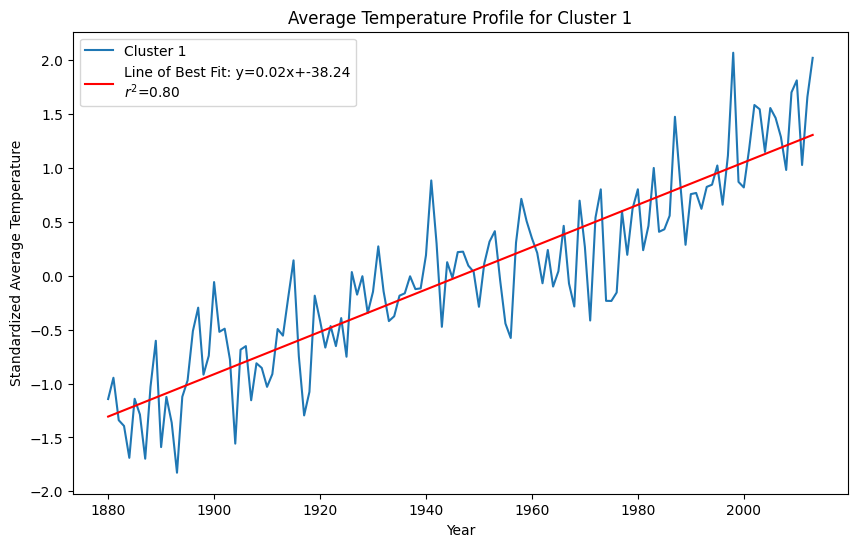

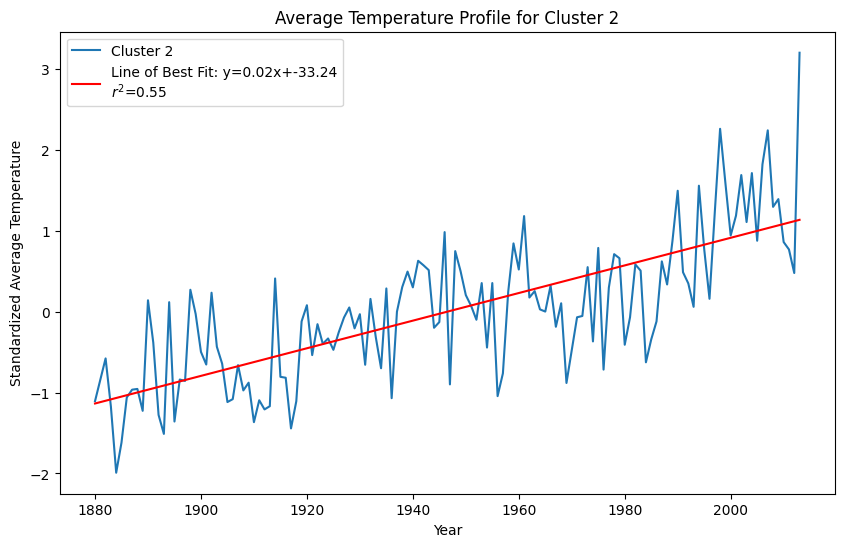

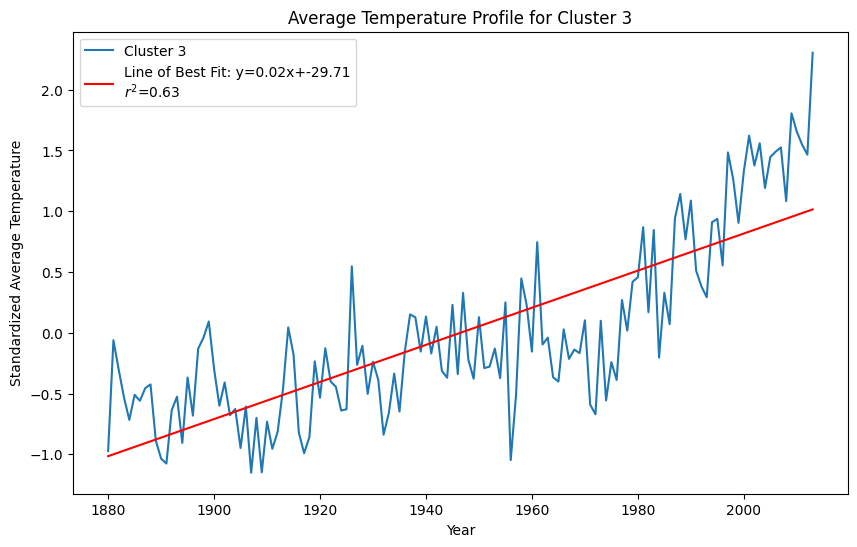

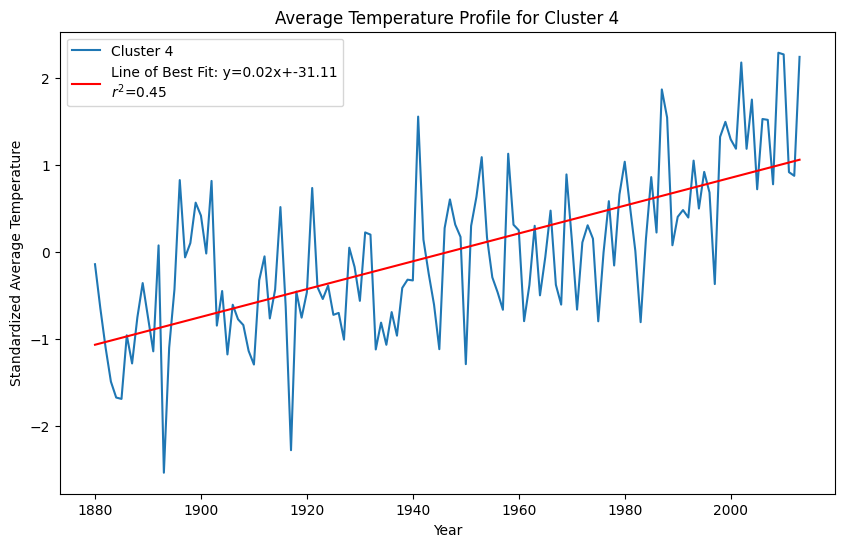

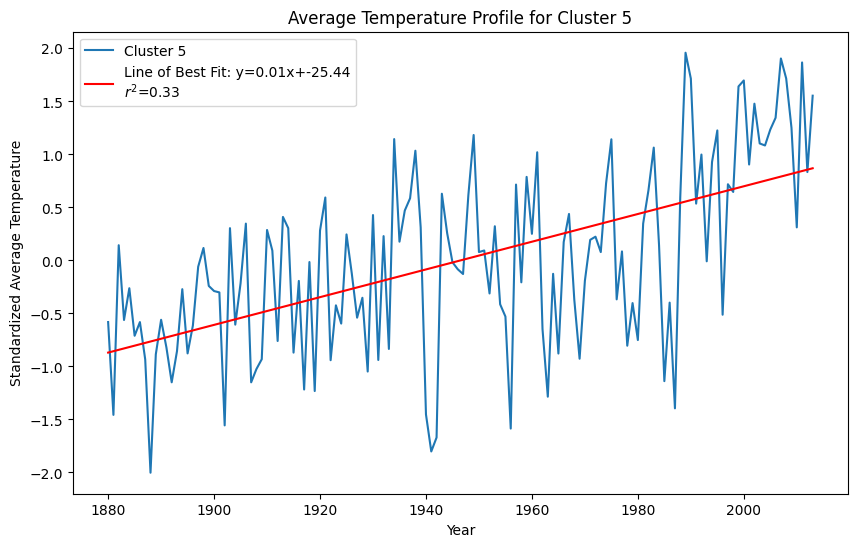

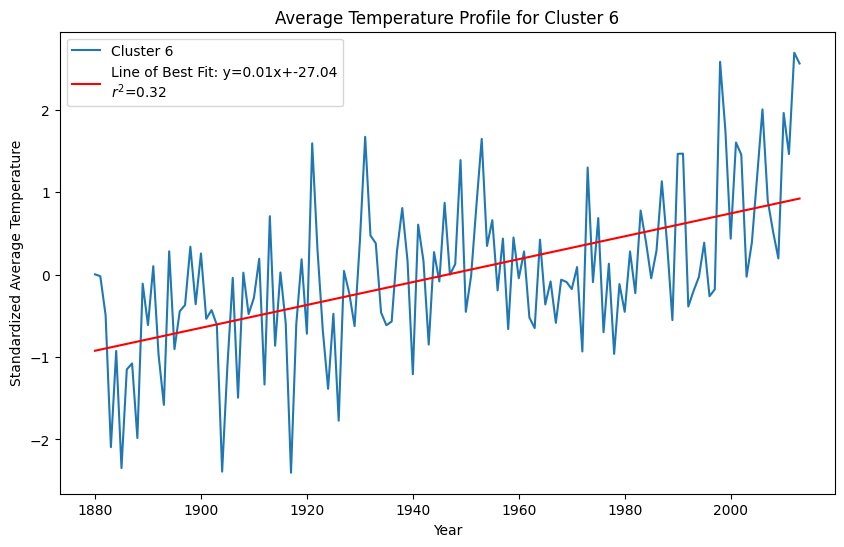

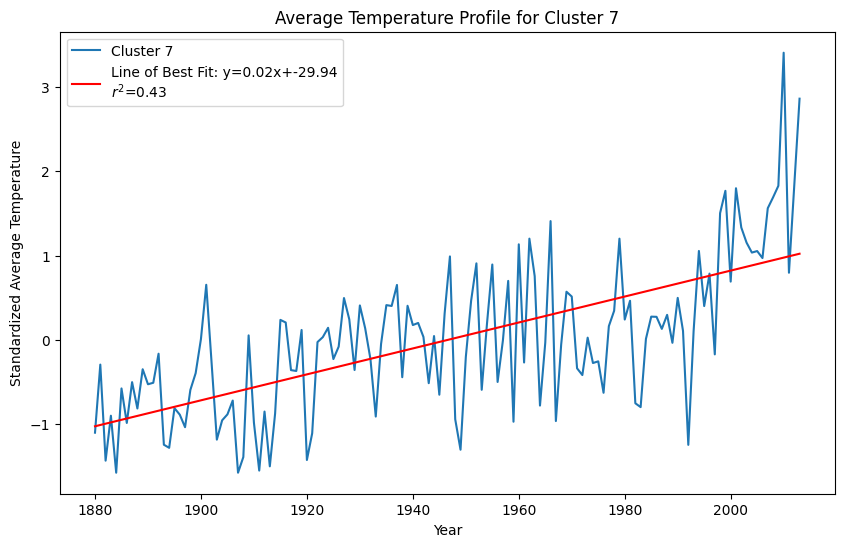

In [14]:
for cluster in range(n_clusters):
    # Extract cities belonging to the current cluster
    cluster_cities = city_cluster_map[city_cluster_map['Cluster'] == cluster]['City']
    cluster_profiles = city_profiles_standardized[cluster_cities]
    
    plt.figure(figsize=(10, 6))


    mean_profile = cluster_profiles.mean(axis=1)
    plt.plot(mean_profile.index, mean_profile.values, label=f'Cluster {cluster + 1}')

    # line of best fit
    slope, intercept, r_value, _, _ = linregress(mean_profile.index.astype(float), mean_profile.values)
    line = slope * mean_profile.index.astype(float) + intercept
    plt.plot(mean_profile.index, line, 'r', label=f'Line of Best Fit: y={slope:.2f}x+{intercept:.2f}\n$r^2$={r_value**2:.2f}')
    
    plt.title(f'Average Temperature Profile for Cluster {cluster + 1}')
    plt.xlabel('Year')
    plt.ylabel('Standardized Average Temperature')
    plt.legend()
    plt.show()

View each non-averaged cluster for comparison

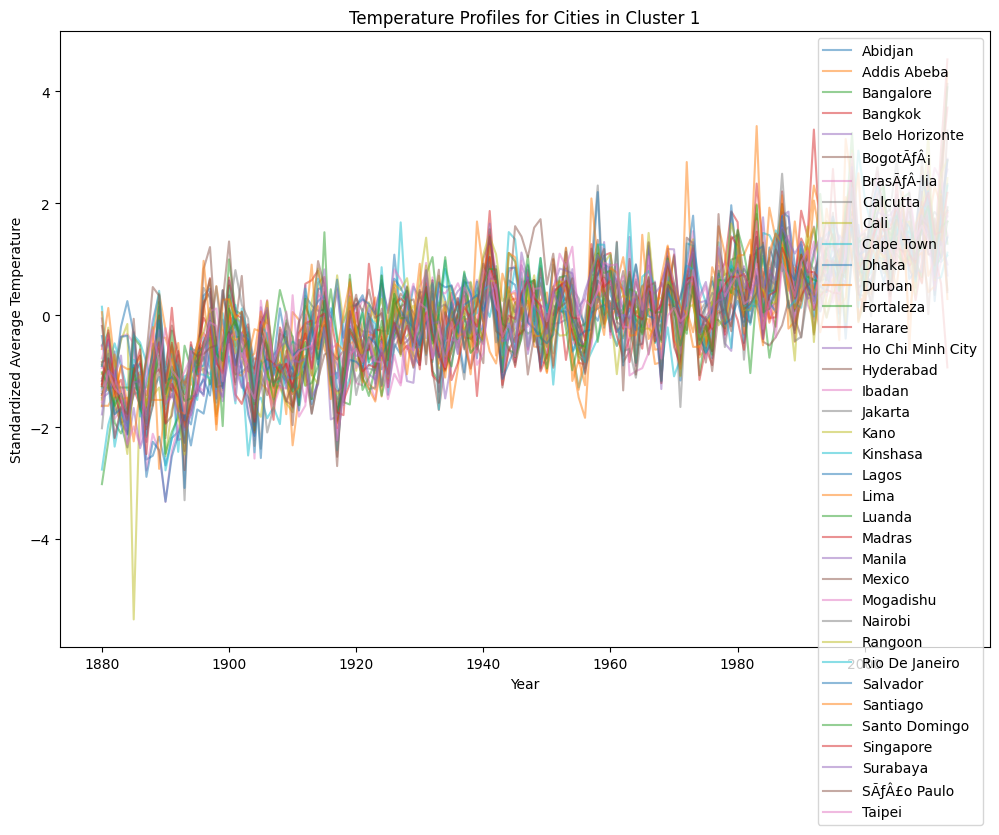

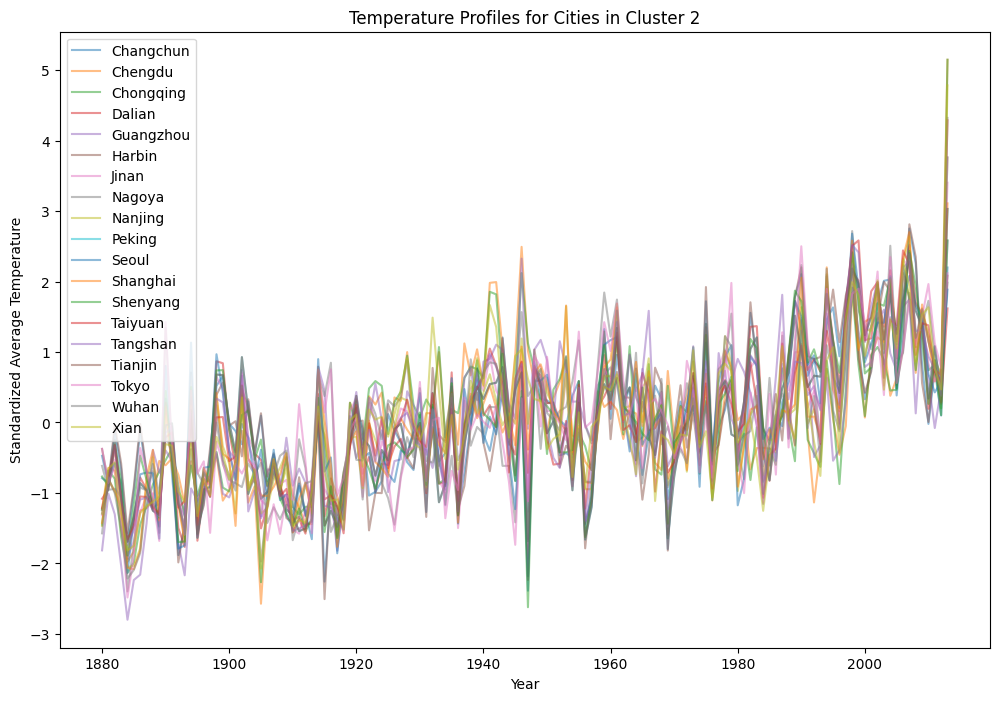

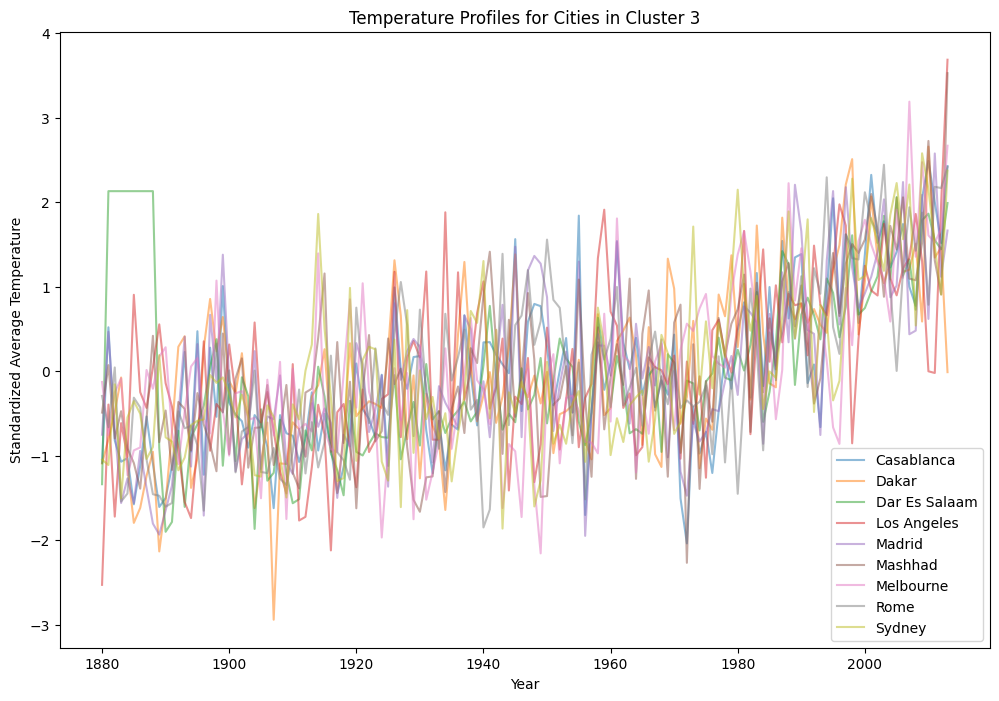

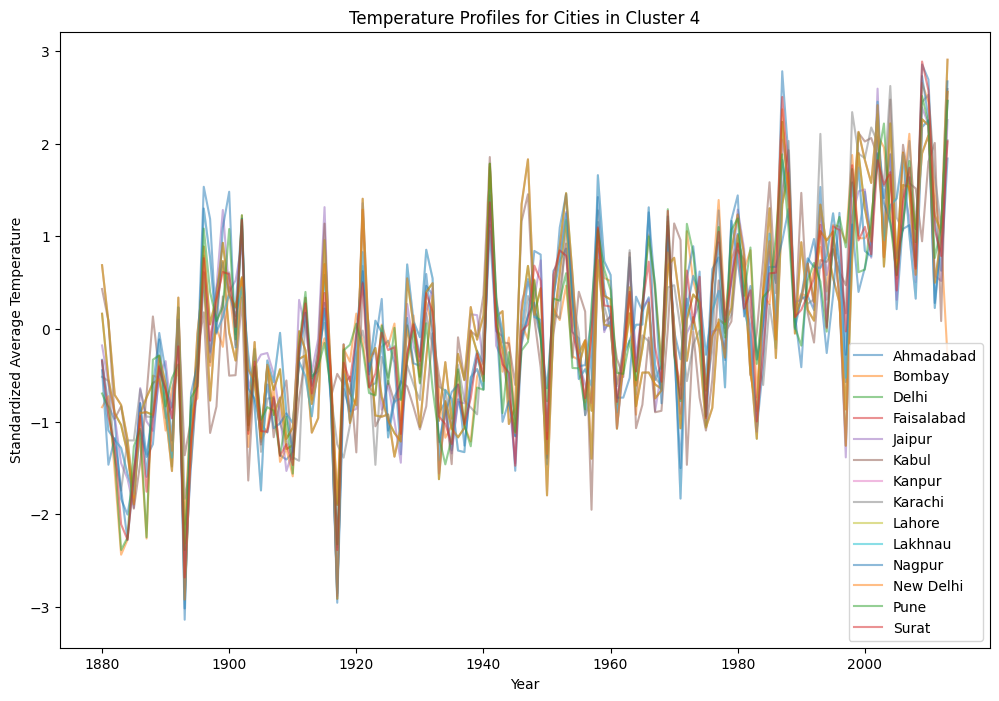

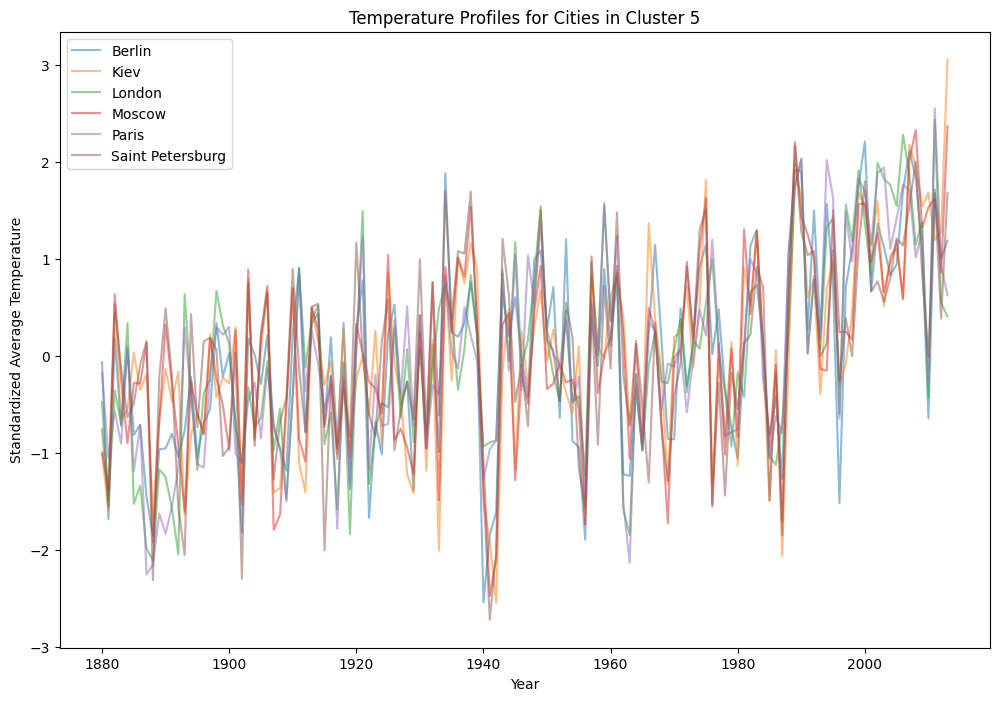

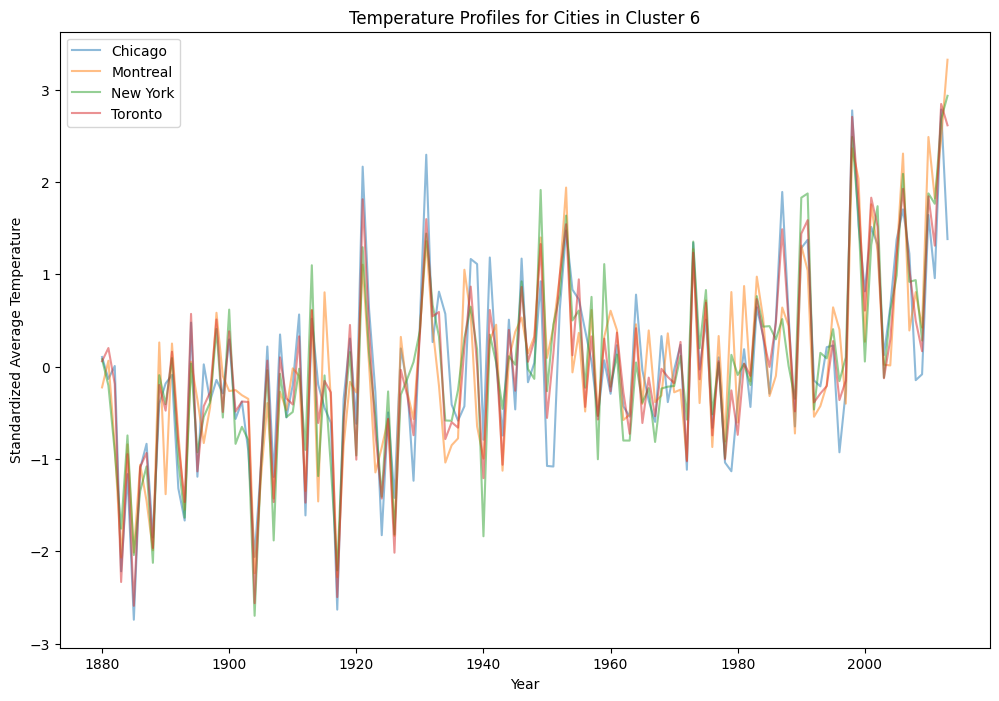

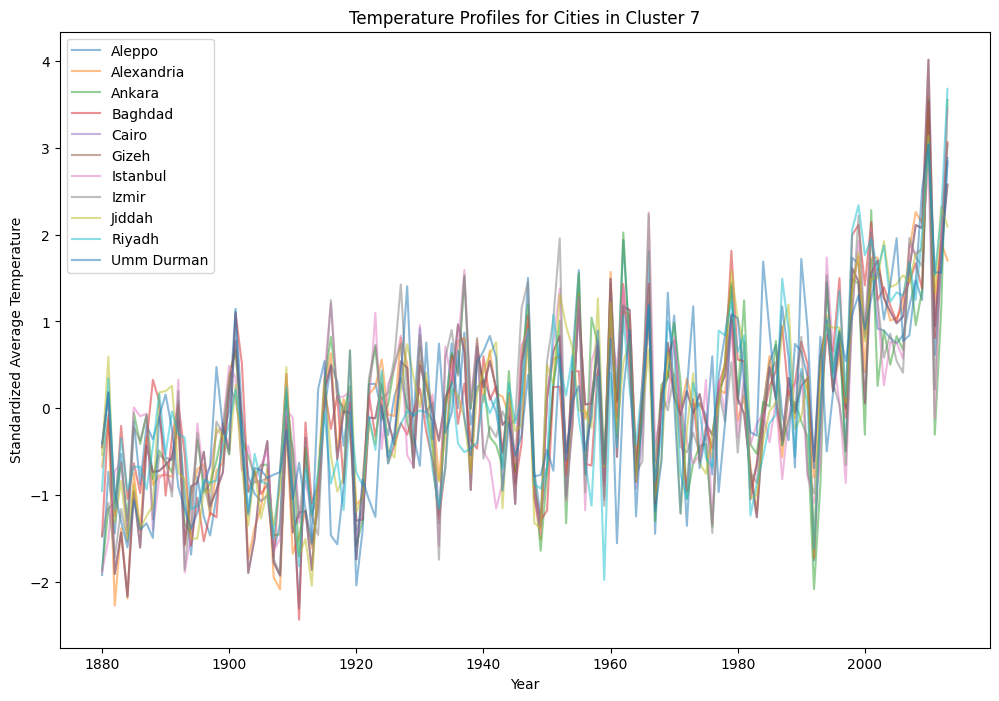

In [15]:
for i in range(n_clusters):
    cluster_cities = city_profiles_standardized.columns[agg_labels == i]

    plt.figure(figsize=(12, 8))
    for city in cluster_cities:
        plt.plot(city_profiles_standardized.index, city_profiles_standardized[city], alpha=0.5, label=city)

    plt.title(f'Temperature Profiles for Cities in Cluster {i+1}')
    plt.xlabel('Year')
    plt.ylabel('Standardized Average Temperature')
    plt.legend()
    plt.show()

View clusters based on MDS

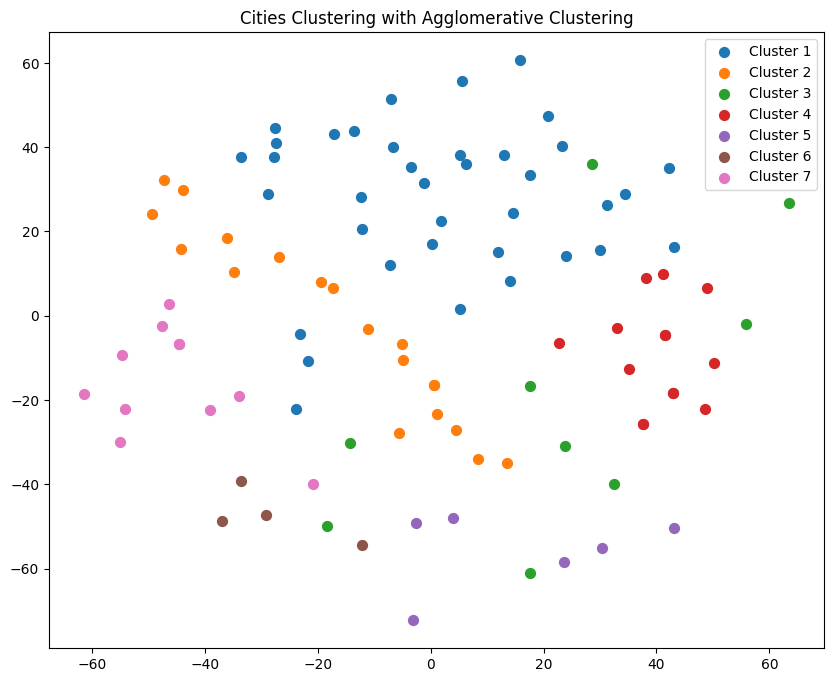

In [16]:
plt.figure(figsize=(10, 8))

# Scatter plot of the two dimensions, colored by cluster label
for i in range(n_clusters):
    # Select only data observations with cluster label == i
    cluster = matrix_cities[agg_labels == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], s=50, label=f'Cluster {i+1}')

plt.title('Cities Clustering with Agglomerative Clustering')
plt.legend()
plt.show()

Look at number of unique Cities and Countries in each cluster

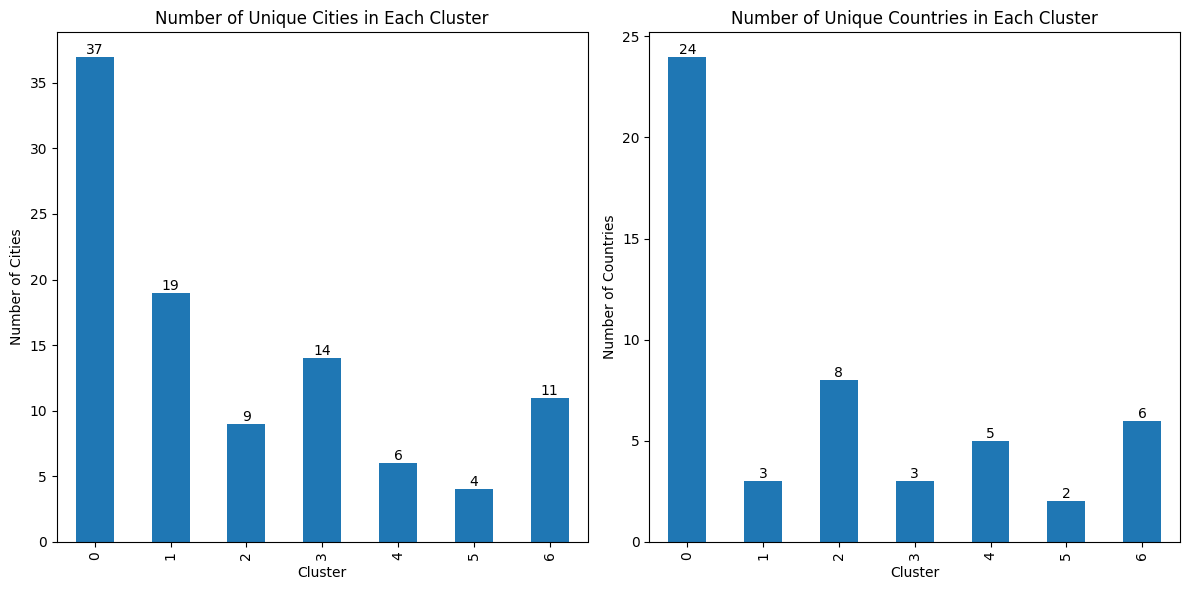

In [17]:
df_merged = pd.merge(df, city_cluster_map, on='City', how='left')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
city_counts = df_merged.groupby('Cluster')['City'].nunique()
city_counts.plot(kind='bar')
plt.title('Number of Unique Cities in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Cities')
for index, value in enumerate(city_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.subplot(1, 2, 2)
country_counts = df_merged.groupby('Cluster')['Country'].nunique()
country_counts.plot(kind='bar')
plt.title('Number of Unique Countries in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Countries')
for index, value in enumerate(country_counts):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Relative abundance of Continents for each cluster vs. unclustered data

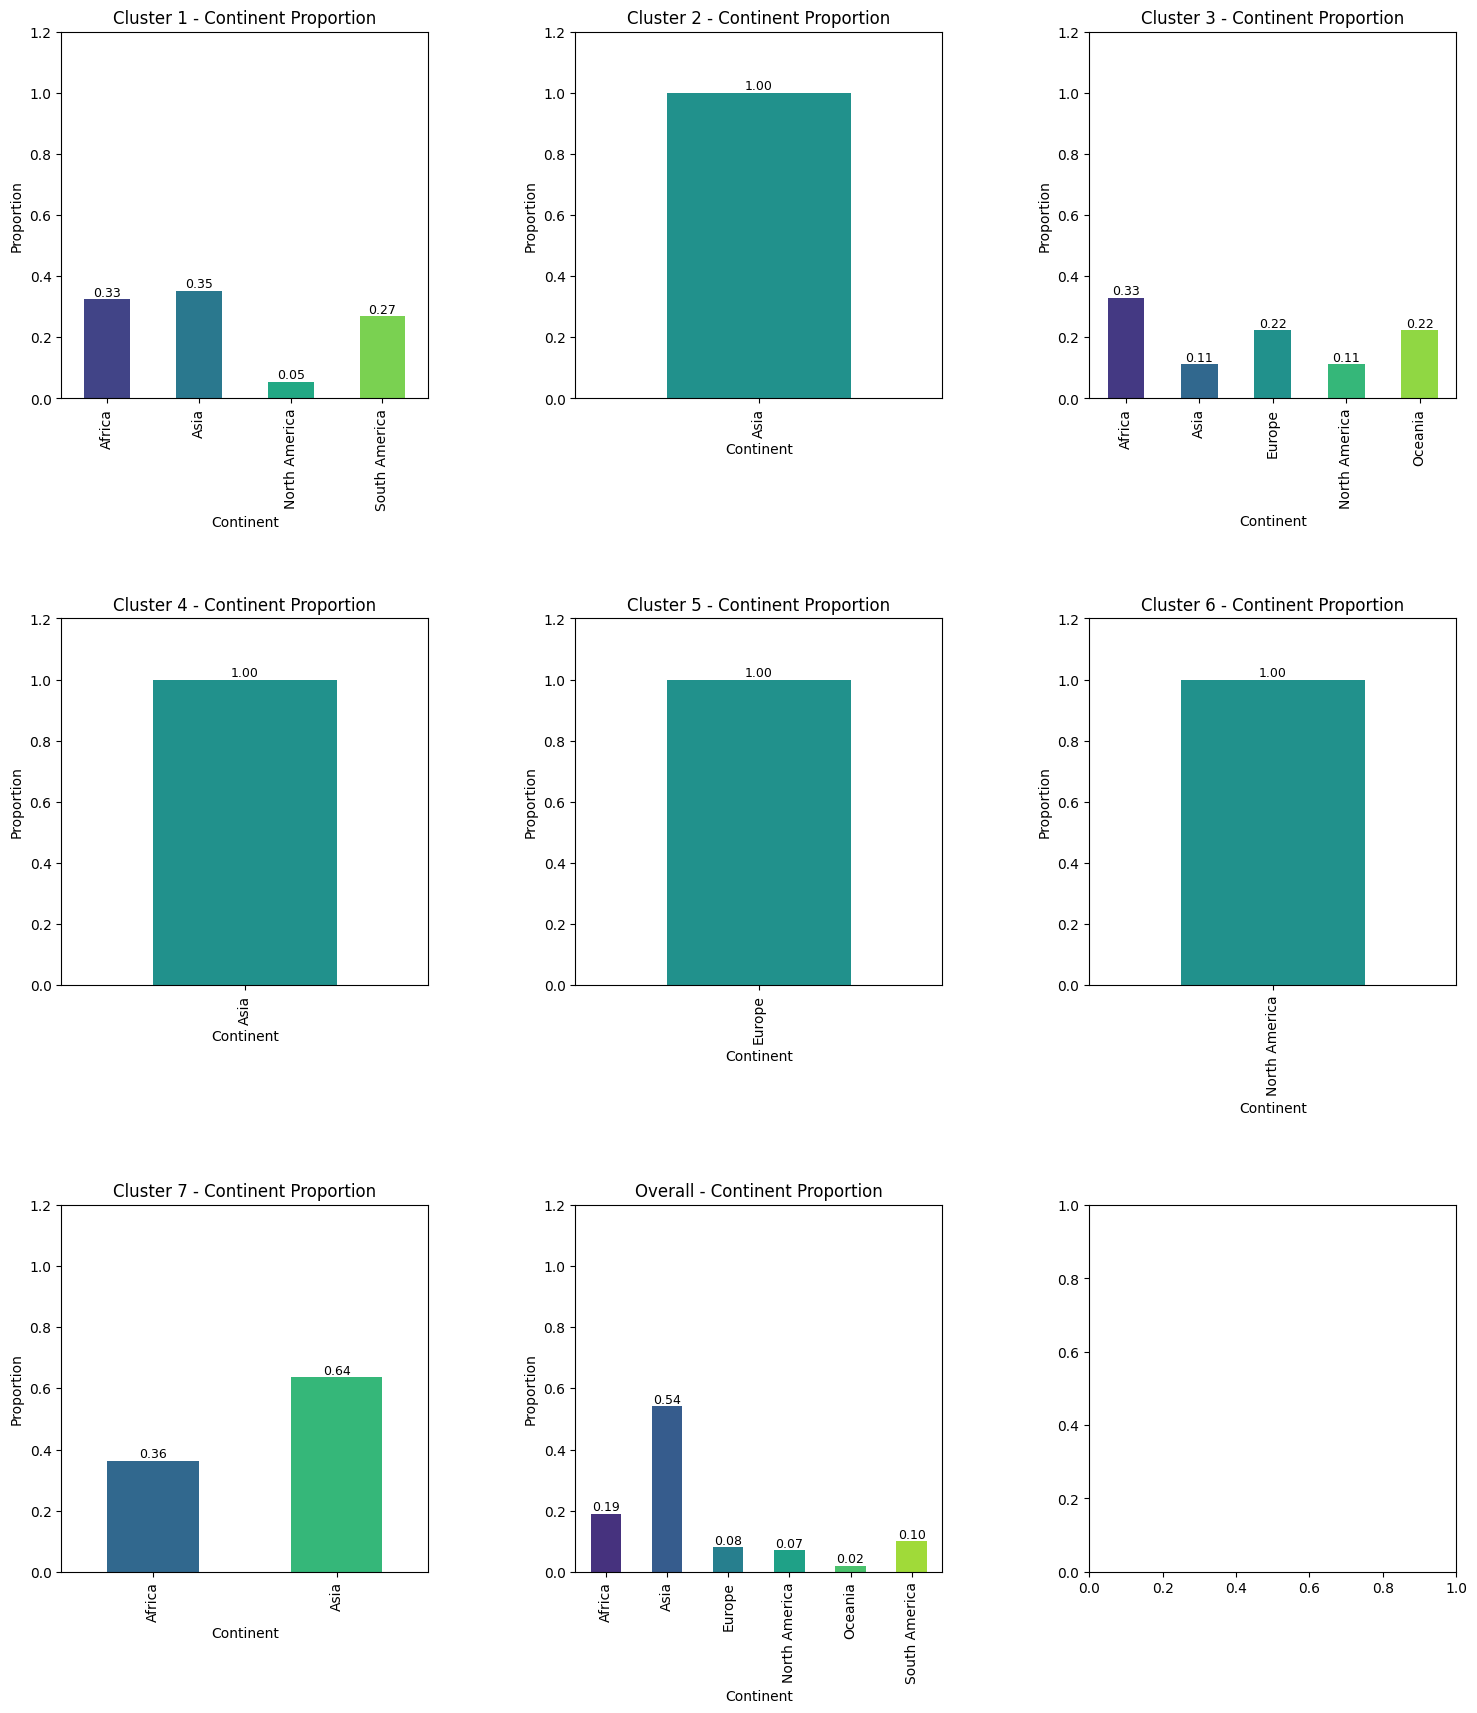

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(18, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

def add_labels(ax, series):
    for index, value in enumerate(series):
        ax.text(index, value, f"{value:.2f}", ha='center', va='bottom', fontsize=9, color='black')

for i in range(n_clusters):
    ax = axs.flat[i]
    cluster_continent_abundance = df_merged[df_merged['Cluster'] == i]['Continent'].value_counts(normalize=True).sort_index()
    cluster_continent_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(cluster_continent_abundance)))
    ax.set_title(f'Cluster {i+1} - Continent Proportion')
    ax.set_ylabel('Proportion')
    ax.set_ylim(0, 1.2)
    add_labels(ax, cluster_continent_abundance)

ax = axs.flat[n_clusters]
overall_continent_abundance = df['Continent'].value_counts(normalize=True).sort_index()
overall_continent_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(overall_continent_abundance)))
ax.set_title('Overall - Continent Proportion')
ax.set_ylabel('Proportion')
ax.set_ylim(0, 1.2)
add_labels(ax, overall_continent_abundance)

Relative abundance of Koppen Climate Classifications (kccs) for each cluster vs. unclustered data

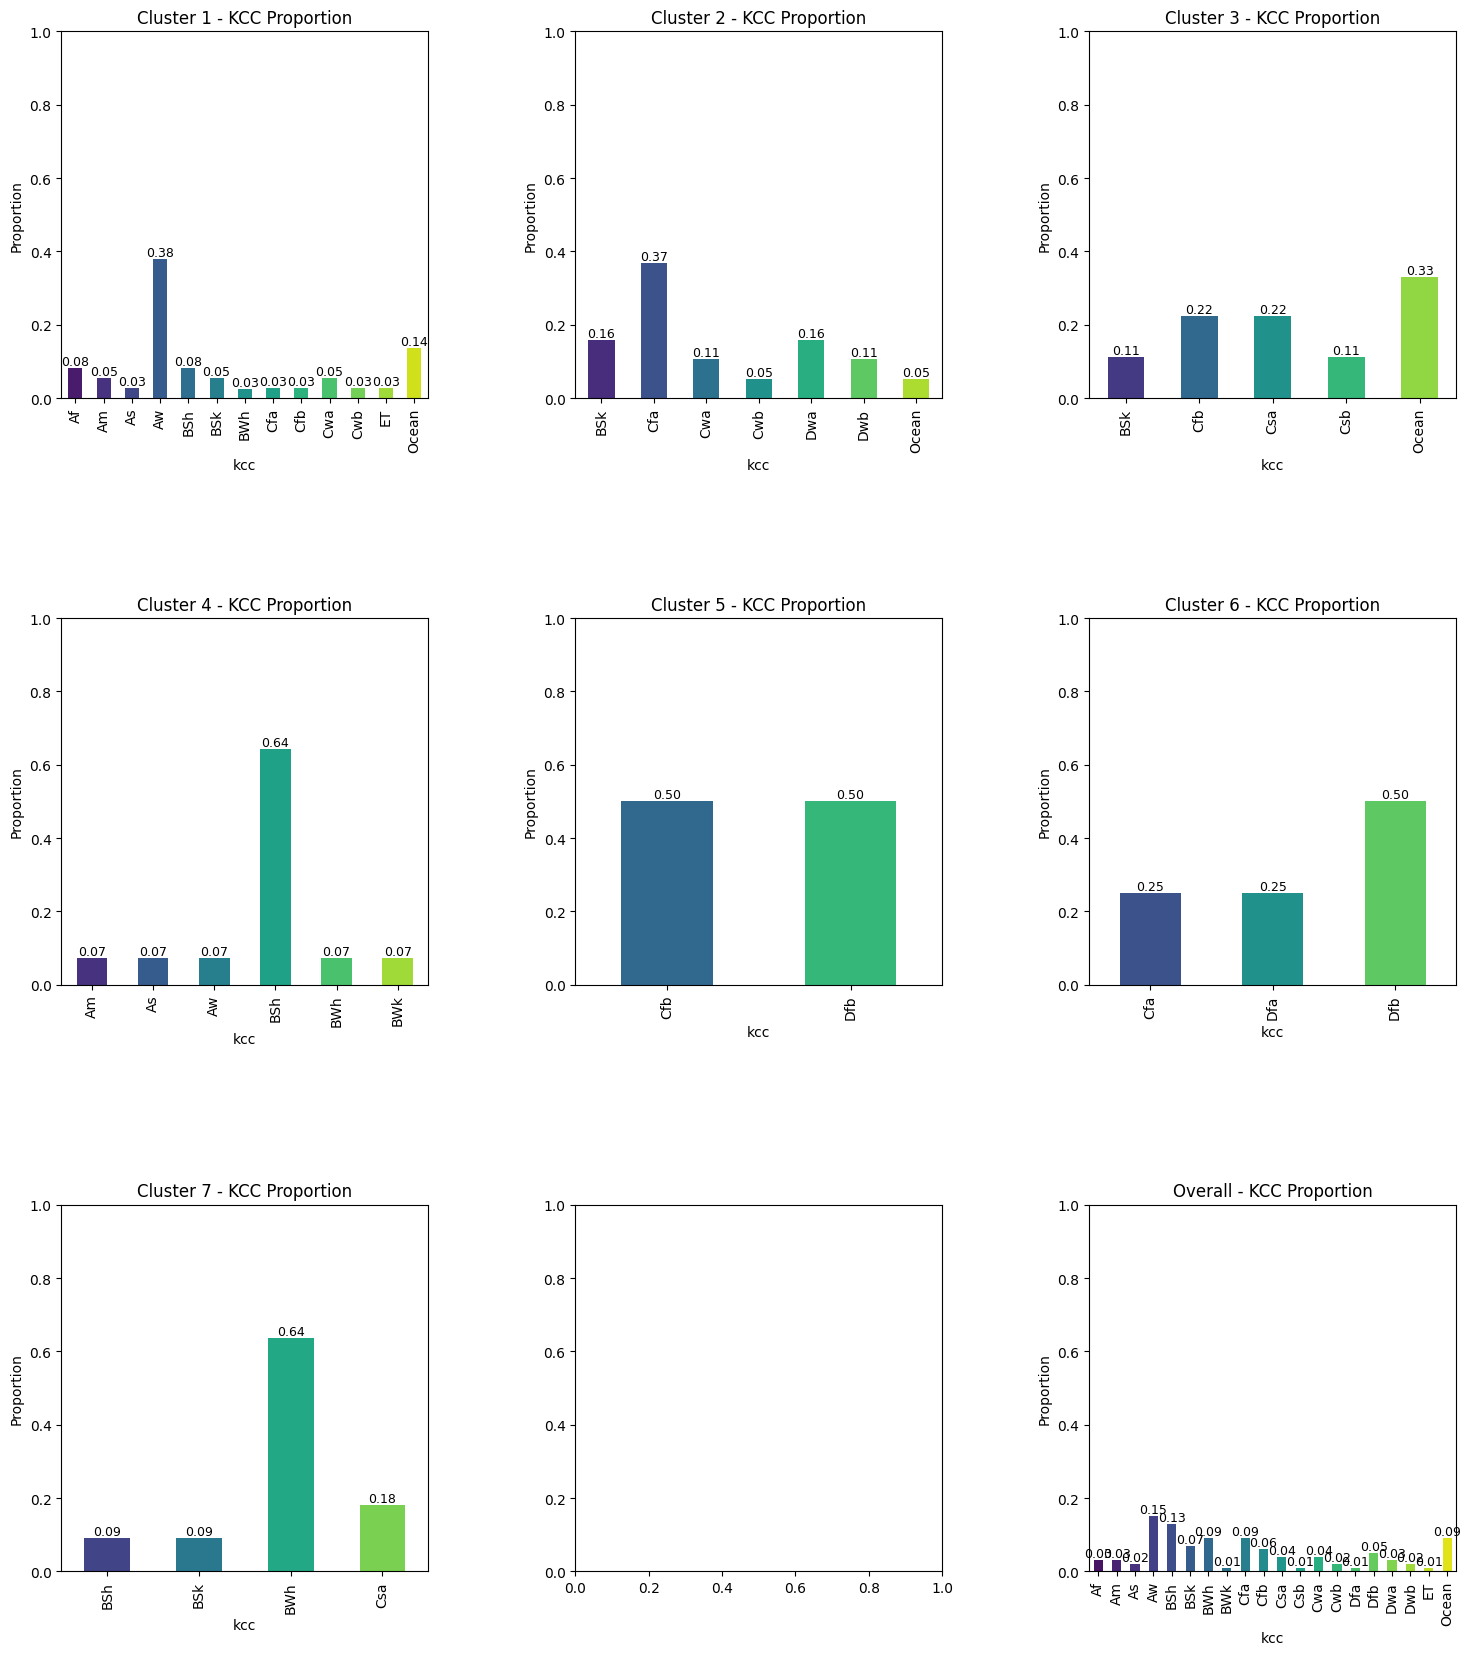

In [19]:
fig, axs = plt.subplots(3, 3, figsize=(18, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(n_clusters):
    ax = axs.flat[i]
    cluster_kcc_abundance = df_merged[df_merged['Cluster'] == i]['kcc'].value_counts(normalize=True).sort_index()
    cluster_kcc_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(cluster_kcc_abundance)))
    ax.set_title(f'Cluster {i+1} - KCC Proportion')
    ax.set_ylabel('Proportion')
    ax.set_ylim(0, 1)
    add_labels(ax, cluster_kcc_abundance)


ax = axs.flat[-1]
overall_kcc_abundance = df['kcc'].value_counts(normalize=True).sort_index()
overall_kcc_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(overall_kcc_abundance)))
ax.set_title('Overall - KCC Proportion')
ax.set_ylabel('Proportion')
ax.set_ylim(0, 1)
add_labels(ax, overall_kcc_abundance)

Summarizing the relative abundance of each continent and each climate classification in each cluster compared to the overall dataset:

Continent|Cluster 1 Δ|Cluster 2 Δ|Cluster 3 Δ|Cluster 4 Δ|Cluster 5 Δ|Cluster 6 Δ|Cluster 7 Δ|
--------:|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
Africa|0.14|-0.19|0.14|-0.19|-0.19|-0.19|0.17
Asia|-0.19|0.46|-0.43|0.46|-0.54|-0.54|0.10
Europe|-0.08|-0.08|0.14|-0.08|0.92|-0.08|-0.08
North America|-0.02|-0.07|0.04|-0.07|-0.07|0.93|-0.07
Oceania|-0.02|-0.02|0.20|-0.02|-0.02|-0.02|-0.02
South America|0.17|-0.10|-0.10|-0.10|-0.10|-0.10|-0.10

<br>

Continent|Cluster 1 Δ|Cluster 2 Δ|Cluster 3 Δ|Cluster 4 Δ|Cluster 5 Δ|Cluster 6 Δ|Cluster 7 Δ|
--------:|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
Af|0.05|-0.03|-0.03|-0.03|-0.03|-0.03|-0.03
Am|0.02|-0.03|-0.03|0.04|-0.03|-0.03|-0.03
As|0.01|-0.02|-0.02|0.05|-0.02|-0.02|-0.02
Aw|0.23|-0.15|-0.15|-0.08|-0.15|-0.15|-0.15
BSh|-0.05|-0.13|-0.13|0.51|-0.13|-0.13|-0.04
BSk|-0.02|0.09|-0.07|-0.07|-0.07|-0.07|0.02
BWh|-0.06|-0.09|-0.09|-0.02|-0.09|-0.09|0.55
BWk|-0.01|-0.01|0.10|0.06|-0.01|-0.01|-0.01
Cfa|-0.06|0.28|-0.09|-0.09|-0.09|0.16|-0.09
Cfb|-0.03|-0.06|0.16|-0.06|0.44|-0.06|-0.06
Csa|-0.04|-0.04|0.18|-0.04|-0.04|-0.04|0.14
Csb|-0.01|-0.01|0.10|-0.01|-0.01|-0.01|-0.01
Cwa|0.01|0.07|-0.04|-0.04|-0.04|-0.04|-0.04
Cwb|0.01|0.03|-0.02|-0.02|-0.02|-0.02|-0.02
Dfa|-0.01|-0.01|-0.01|-0.01|-0.01|0.24|-0.01
Dfb|-0.05|-0.05|-0.05|-0.05|0.45|0.45|-0.05
Dwa|-0.03|0.13|-0.03|-0.03|-0.03|-0.03|-0.03
Dwb|-0.02|0.09|-0.02|-0.02|-0.02|-0.02|-0.02
ET|0.02|-0.01|-0.01|-0.01|-0.01|-0.01|-0.01
Ocean|0.05|-0.04|0.24|-0.09|-0.09|-0.09|-0.09


Visualize relative abundances of continent and kccs as a heatmap

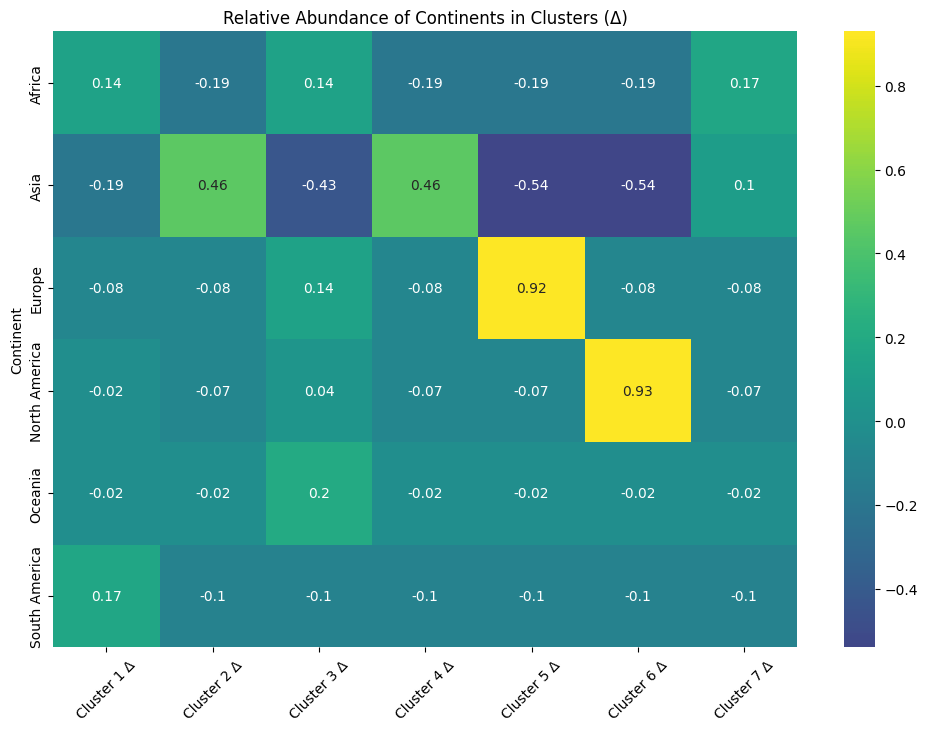

In [20]:
data = {
    'Continent': ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'],
    'Cluster 1 Δ': [0.14, -0.19, -0.08, -0.02, -0.02, 0.17],
    'Cluster 2 Δ': [-0.19, 0.46, -0.08, -0.07, -0.02, -0.10],
    'Cluster 3 Δ': [0.14, -0.43, 0.14, 0.04, 0.20, -0.10],
    'Cluster 4 Δ': [-0.19, 0.46, -0.08, -0.07, -0.02, -0.10],
    'Cluster 5 Δ': [-0.19, -0.54, 0.92, -0.07, -0.02, -0.10],
    'Cluster 6 Δ': [-0.19, -0.54, -0.08, 0.93, -0.02, -0.10],
    'Cluster 7 Δ': [0.17, 0.10, -0.08, -0.07, -0.02, -0.10]
}
df_deltas = pd.DataFrame(data)
df_deltas = df_deltas.set_index('Continent')

plt.figure(figsize=(12, 8))
sns.heatmap(df_deltas, annot=True, cmap="viridis", center=0)
plt.title('Relative Abundance of Continents in Clusters (Δ)')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.show()

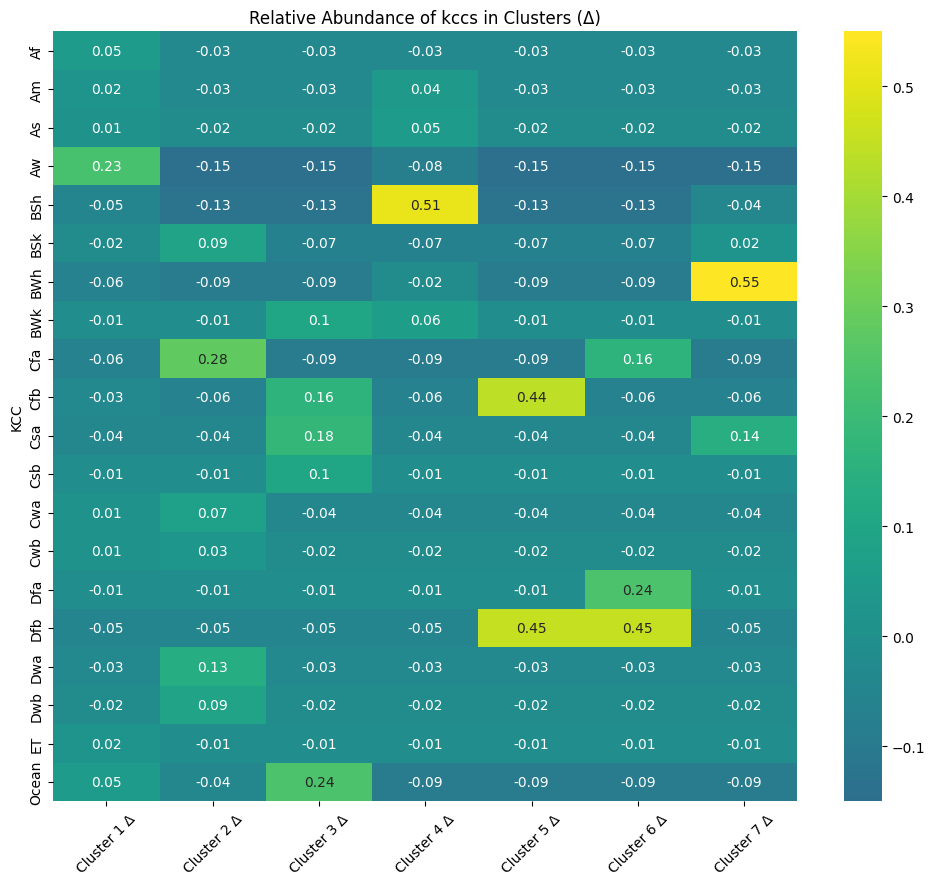

In [21]:
data = {
    'KCC': ['Af', 'Am', 'As', 'Aw', 'BSh', 'BSk', 'BWh', 'BWk', 
            'Cfa', 'Cfb', 'Csa', 'Csb', 'Cwa', 'Cwb', 
            'Dfa', 'Dfb', 'Dwa', 'Dwb', 'ET', 'Ocean'],
    'Cluster 1 Δ': [0.05, 0.02, 0.01, 0.23, -0.05, -0.02, -0.06, -0.01, 
                    -0.06, -0.03, -0.04, -0.01, 0.01, 0.01, 
                    -0.01, -0.05, -0.03, -0.02, 0.02, 0.05],
    'Cluster 2 Δ': [-0.03, -0.03, -0.02, -0.15, -0.13, 0.09, -0.09, -0.01, 
                    0.28, -0.06, -0.04, -0.01, 0.07, 0.03, 
                    -0.01, -0.05, 0.13, 0.09, -0.01, -0.04],
    'Cluster 3 Δ': [-0.03, -0.03, -0.02, -0.15, -0.13, -0.07, -0.09, 0.10, 
                    -0.09, 0.16, 0.18, 0.10, -0.04, -0.02, 
                    -0.01, -0.05, -0.03, -0.02, -0.01, 0.24],
    'Cluster 4 Δ': [-0.03, 0.04, 0.05, -0.08, 0.51, -0.07, -0.02, 0.06, 
                    -0.09, -0.06, -0.04, -0.01, -0.04, -0.02, 
                    -0.01, -0.05, -0.03, -0.02, -0.01, -0.09],
    'Cluster 5 Δ': [-0.03, -0.03, -0.02, -0.15, -0.13, -0.07, -0.09, -0.01, 
                    -0.09, 0.44, -0.04, -0.01, -0.04, -0.02, 
                    -0.01, 0.45, -0.03, -0.02, -0.01, -0.09],
    'Cluster 6 Δ': [-0.03, -0.03, -0.02, -0.15, -0.13, -0.07, -0.09, -0.01, 
                    0.16, -0.06, -0.04, -0.01, -0.04, -0.02, 
                    0.24, 0.45, -0.03, -0.02, -0.01, -0.09],
    'Cluster 7 Δ': [-0.03, -0.03, -0.02, -0.15, -0.04, 0.02, 0.55, -0.01, 
                    -0.09, -0.06, 0.14, -0.01, -0.04, -0.02, 
                    -0.01, -0.05, -0.03, -0.02, -0.01, -0.09],
}

df_kcc_deltas = pd.DataFrame(data)
df_kcc_deltas = df_kcc_deltas.set_index('KCC')

plt.figure(figsize=(12, 10))
sns.heatmap(df_kcc_deltas, annot=True, cmap="viridis", center=0)
plt.title('Relative Abundance of kccs in Clusters (Δ)')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.show()

Geographic spread of clusters:

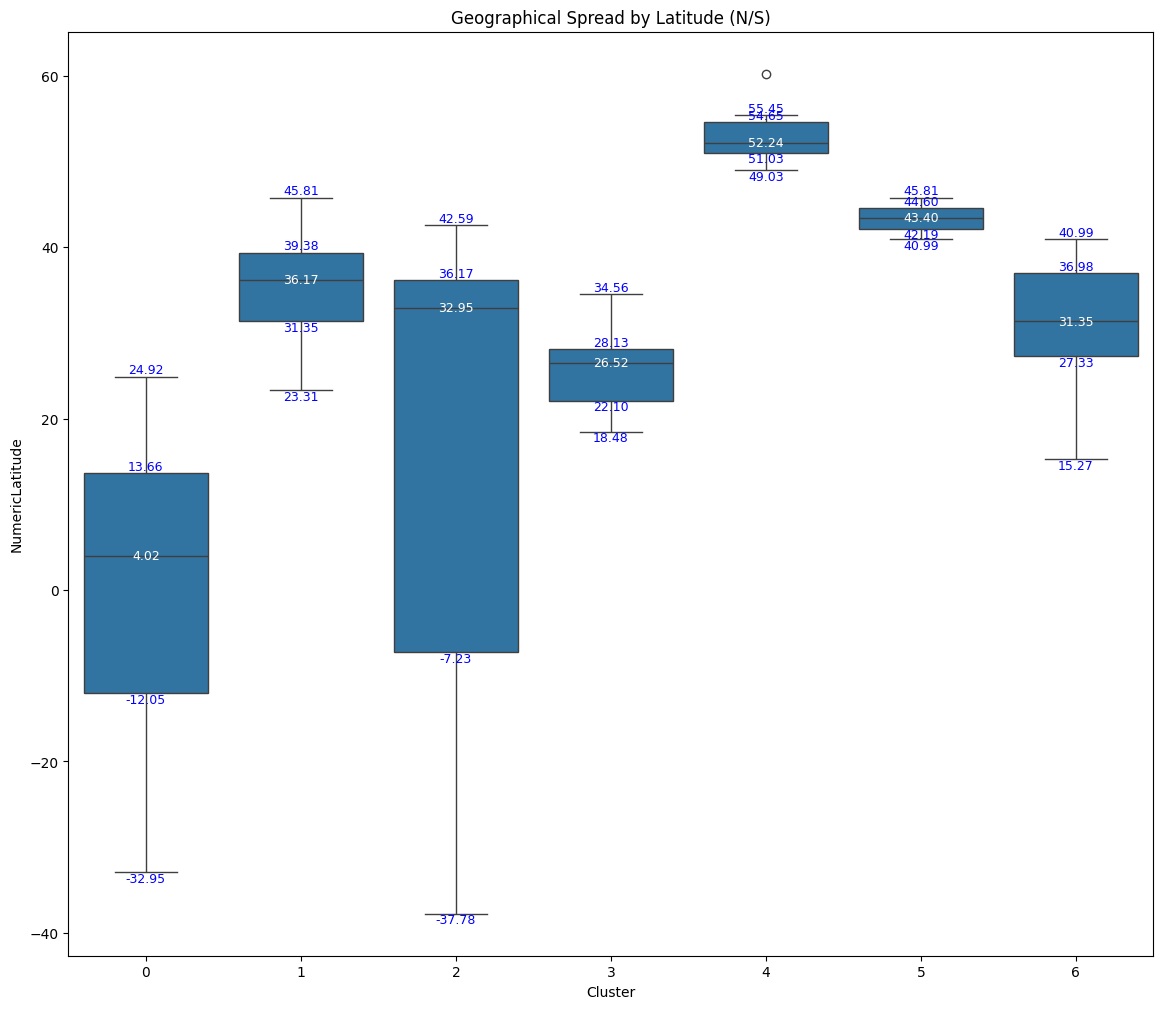

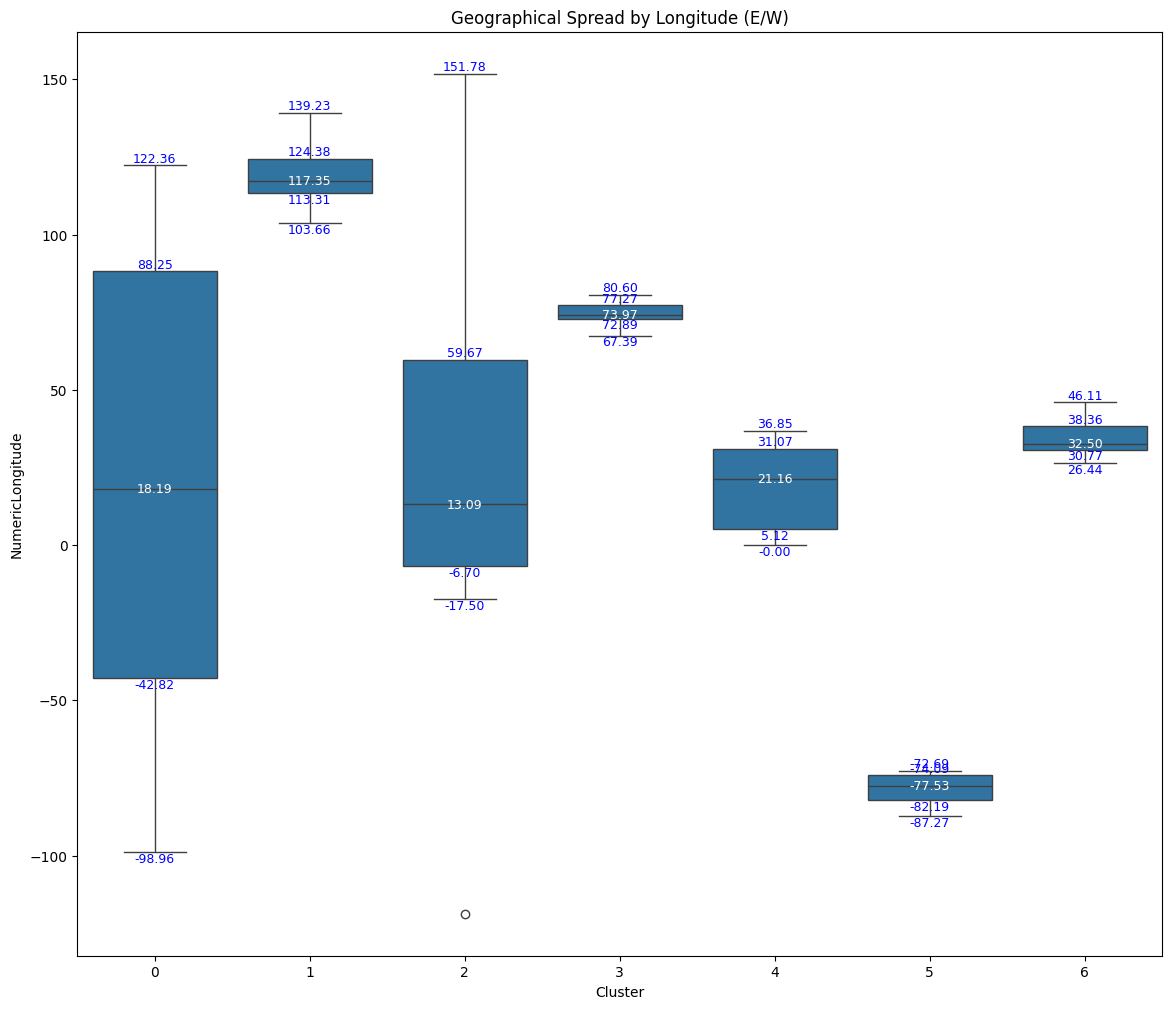

In [23]:
# Latitude
plt.figure(figsize=(14, 12))
sns.boxplot(x='Cluster', y='NumericLatitude', data=df_hierarchical)

num_clusters = df_hierarchical['Cluster'].nunique()
for i in range(num_clusters):
    cluster_latitudes = df_hierarchical[df_hierarchical['Cluster'] == i]['NumericLatitude']
    percentiles = np.percentile(cluster_latitudes, [25, 50, 75])  # Q1, Median, Q3
    lower_whisker = np.min(cluster_latitudes[cluster_latitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_latitudes[cluster_latitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    plt.text(i, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(i, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(i, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Latitude (N/S)')
plt.ylabel('NumericLatitude')
plt.xlabel('Cluster')
plt.show()

# Longitude
plt.figure(figsize=(14, 12))
sns.boxplot(x='Cluster', y='NumericLongitude', data=df_hierarchical)
for i in range(num_clusters):
    cluster_Longitudes = df_hierarchical[df_hierarchical['Cluster'] == i]['NumericLongitude']
    percentiles = np.percentile(cluster_Longitudes, [25, 50, 75])  # Q1, Median, Q3
    lower_whisker = np.min(cluster_Longitudes[cluster_Longitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_Longitudes[cluster_Longitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    # Placing text annotations for percentiles
    plt.text(i, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(i, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(i, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Longitude (E/W)')
plt.ylabel('NumericLongitude')
plt.xlabel('Cluster')
plt.show()